In [1]:
import os
import re
import json
import gdal
import datetime
import itertools
import shapefile
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy import stats
from datetime import datetime
from itertools import product
import matplotlib.pyplot as plt
#import sys  
#sys.path.insert(0, '../Calibration')

#import Calibration_functions as fn
#import functions_ground_motion as fgm

import sklearn.metrics as metrics
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

/usr/lib64/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
with open("../file_with_paths.json") as file_with_paths :
    FILE_PATHS = json.load(file_with_paths)

print("The base output directory is {}".format(FILE_PATHS["ground_motion_csv"]))

ground_motion_dir = FILE_PATHS["ground_motion_csv"]
ground_motion_file = ground_motion_dir + ""
# for later: this is how the ground motion data have been saved
#out_dir_csv + 'Timeseries_GroundMotion_pixel'+str(i)+'_'+str(j)+'_failure.csv'


precip_dir = FILE_PATHS["rain_intensity_caliv_valid"]
out_dir = FILE_PATHS["time_series_ml"]

# Here comes the rain again
rain_dir = FILE_PATHS["rain_dir"]
rain_file = rain_dir + "2014-01-01_to_2019-12-31_Intensity.csv"

demdir = FILE_PATHS['topo_dir']
demfile = demdir + "10mDEM_tinitaly/w45510_s10_AoI_32633.bil"


# road file
roaddir = FILE_PATHS["road_dir"]
roadfile = roaddir + "Road_line.shp" # this is in EPSG:32633

merged_ground_motion_distance_dir = FILE_PATHS["ground_motion_csv"]
merged_ground_motion_distance_file = merged_ground_motion_distance_dir + "10mDEM_merged_result.csv"



The base output directory is /exports/csce/datastore/geos/groups/LSDTopoData/FORESEE/Data/ground_motion_csv/


In [3]:
########## read pixel position data ##################

ground_motion_distance_pxl = pd.read_csv(merged_ground_motion_distance_file)
ground_motion_distance_pxl = np.array(ground_motion_distance_pxl)

# the first column only has indices - we don't need that.
ground_motion_distance_pxl = ground_motion_distance_pxl[:,1:]

ground_motion_distance_df = pd.DataFrame({'ground_motion': ground_motion_distance_pxl[:, 0], 'time': ground_motion_distance_pxl[:, 1], 'slope': ground_motion_distance_pxl[:,2], 'curvature': ground_motion_distance_pxl[:,3], 'aspect': ground_motion_distance_pxl[:,4],'rows': ground_motion_distance_pxl[:,5],'cols': ground_motion_distance_pxl[:,6], 'datasource': ground_motion_distance_pxl[:,7], 'distance_to_road': ground_motion_distance_pxl[:,8]})


ground_motion_distance_df['time'] =  pd.to_datetime(ground_motion_distance_df['time'])

####### need to add the rainfall data to the datafram as well. forgot to do this ###########
rain_data = pd.read_csv(rain_file)
rain_data = np.array(rain_data)
rain_data_df = pd.DataFrame({'rain_intensity_mm_sec':rain_data[:,1]})
date_list = pd.date_range(start="2014-01-01", end="2018-12-31")

rain_data_df['time'] = date_list


# ground motion data goes all the way to end of 2019 but the rainfall data is only until end of 2018
result_with_rain = pd.merge(ground_motion_distance_df, rain_data_df, how='left', on=['time'])
result_with_rain = result_with_rain.set_index('time')
result_with_rain = result_with_rain.sort_values('time', ascending=True)

result_with_rain.to_csv(ground_motion_dir+'10mDEM_merged_result_with_rain.csv')
print(result_with_rain.info(verbose=False))



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2293158 entries, 2014-12-31 to 2019-04-03
Columns: 9 entries, ground_motion to rain_intensity_mm_sec
dtypes: float64(1), object(8)
memory usage: 175.0+ MB
None


The code below only corresponds to the bits that need to be produced only once. There is no need to run this code below every time because the main file will already have been produced. 

In [4]:
rainfall_timeseries = result_with_rain.index.unique()


/usr/lib64/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


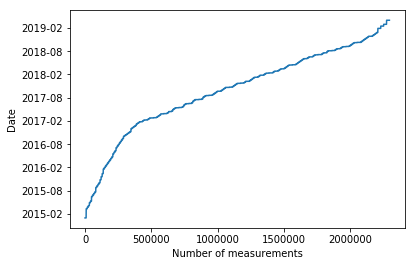

In [4]:
plt.plot(result_with_rain.index)
plt.xlabel("Number of measurements")
plt.ylabel("Date")
plt.savefig("number_of_measurements1.png")

In [11]:
result_with_rain.tail()

,ground_motion,slope,curvature,aspect,rows,cols,datasource,distance_to_road,rain_intensity_mm_sec
time,,,,,,,,,
2019-04-03,7.57476,0.17831,-0.00205627,32.1655,1552,2373,1,2.43129e+09,NaN
2019-04-03,2.56938,0.215576,7.74862e-05,90.6893,1397,1979,1,2.39382e+09,NaN
2019-04-03,2.21982,0.0407377,-0.000499,264.294,1244,3422,1,2.53786e+09,NaN
2019-04-03,9.83031,0.124155,-0.00128728,216.496,1318,2426,1,2.43823e+09,NaN
2019-04-03,8.35857,0.150267,-2.63888e-06,106.913,1375,1997,1,2.39574e+09,NaN


In [ ]:
# pd.DataFrame([{'time': k,
#                         'price': (v.price * v.volume).sum() / v.volume.sum(),
#                         'volume': v.volume.mean()}
#                        for k,v in a.groupby(['time'])],
#                       columns=['time', 'price', 'volume'])

In [25]:
result_with_rain = result_with_rain.reset_index()

In [ ]:
plt.stem(result_with_rain['rain_intensity_mm_sec']*3600*24, markerfmt=" ")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Rainfall (mm/day)")
plt.savefig("rainfall_timeseries.png")

In [ ]:
result_with_rain.head()

In [ ]:
result_with_rain["sign"] 
result_with_rain["final_gm"] 

In [188]:
result_with_rain_2 = result_with_rain[:1000]

In [ ]:
result_with_rain_2

In [75]:
# Remove duplicates of the ground motion data. If multiple points within the same pixel,
# choose the one with the highest ground motion 
def gm_function(v):
    num_ground_motion = pd.to_numeric(v.ground_motion)
    index = num_ground_motion.abs().idxmax()
    return v.ground_motion[index]

a = pd.DataFrame(
    [
        {
            'rain_intensity_mm_sec': k[8],
            'distance_to_road': k[7],
            'datasource': k[6],
            'aspect': k[5],
            'curvature': k[4],
            'slope': k[3],
            'time': k[2],
            'rows': k[0],
            'cols': k[1],
            'ground_motion': gm_function(v)
        }
        for k,v in result_with_rain.groupby(['rows','cols', 'time', 'slope', 'curvature', 'aspect', 'datasource', 'distance_to_road', 'rain_intensity_mm_sec'])],
    columns=['time','rows', 'cols','ground_motion','slope', 'curvature', 'aspect', 'datasource', 'distance_to_road', 'rain_intensity_mm_sec']
)

In [76]:
a.tail()

,time,rows,cols,ground_motion,slope,curvature,aspect,datasource,distance_to_road,rain_intensity_mm_sec
2199021,2018-12-04,2580,2684,17.32,0.074263,-0.002723,88.678833,0.0,2.455702e+09,3.969236e-08
2199022,2018-12-10,2580,2684,23.28,0.074263,-0.002723,88.678833,0.0,2.455702e+09,9.461043e-06
2199023,2018-12-16,2580,2684,24.1,0.074263,-0.002723,88.678833,0.0,2.455702e+09,2.248211e-08
2199024,2018-12-22,2580,2684,21.91,0.074263,-0.002723,88.678833,0.0,2.455702e+09,1.898163e-04
2199025,2018-12-28,2580,2684,21.03,0.074263,-0.002723,88.678833,0.0,2.455702e+09,6.402224e-07


The bit of code below is just to test that the function to remove duplicates work. 

In [13]:
#selects the duplicated rows 
duplicateRowsDF = result_with_rain[result_with_rain.duplicated(["rows","cols", "time"])]

In [14]:
duplicateRowsDF.head()

,time,ground_motion,slope,curvature,aspect,rows,cols,datasource,distance_to_road,rain_intensity_mm_sec
62,2014-12-31,-5.42,0.162571,0.000264618,82.0757,1741,691,0,2.26737e+09,0.000024
73,2014-12-31,-14.27,0.107192,0.000853417,325.325,2220,2255,0,2.41538e+09,0.000024
80,2014-12-31,-2.14,0.168507,0.000417155,109.825,2082,1426,0,2.33554e+09,0.000024
321,2014-12-31,28.09,0.124793,0.000747802,200.518,1690,1781,0,2.37245e+09,0.000024
944,2014-12-31,22.59,0.142745,-7.35854e-06,349.989,466,995,0,2.30658e+09,0.000024


In [200]:
b = result_with_rain.loc[(result_with_rain['rows'] == 1741) & (result_with_rain['cols'] == 691)]

In [201]:
c = a.loc[(a['rows'] == 1741) & (a['cols'] == 691)]

In [202]:
b.head()

,time,ground_motion,slope,curvature,aspect,rows,cols,datasource,distance_to_road,rain_intensity_mm_sec
16,2014-12-31,0.75,0.162571,0.000264618,82.0757,1741,691,0,2.26737e+09,2.445618e-05
62,2014-12-31,-5.42,0.162571,0.000264618,82.0757,1741,691,0,2.26737e+09,2.445618e-05
14384,2015-03-13,-7.48,0.162571,0.000264618,82.0757,1741,691,0,2.26737e+09,3.958338e-07
14390,2015-03-13,0.07,0.162571,0.000264618,82.0757,1741,691,0,2.26737e+09,3.958338e-07
21261,2015-03-25,-0.72,0.162571,0.000264618,82.0757,1741,691,0,2.26737e+09,1.413031e-04


In [203]:
c.head()

,time,rows,cols,ground_motion
1916104,2014-12-31,1741,691,-5.42
1916105,2015-03-13,1741,691,-7.48
1916106,2015-03-25,1741,691,-9.25
1916107,2015-04-06,1741,691,-10.38
1916108,2015-04-30,1741,691,-10.87


In [15]:
result_with_rain['datasource'].value_counts()

0.0    1286080
1.0    1007078
Name: datasource, dtype: int64

In [ ]:
import matplotlib.dates as mdates
fig,ax1 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
plt.scatter(result_with_rain.index,result_with_rain['ground_motion'])
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
monthyearFmt = mdates.DateFormatter('%Y %B')
ax1.xaxis.set_major_formatter(monthyearFmt)
_ = plt.xticks(rotation=90)

In [ ]:
import matplotlib.dates as mdates
fig,ax1 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
plt.scatter(result_with_rain.index,result_with_rain['rows'])


In [29]:
# need to reindex 
result_with_rain = a


In [36]:
result_with_rain.head()

,ground_motion,slope,curvature,aspect,rows,cols,datasource,distance_to_road,rain_intensity_mm_sec
time,,,,,,,,,
2014-12-31,27.21,0.210794,-4.46151e-06,169.203,1055,2313,0,2.42918e+09,0.000024
2014-12-31,3.41,0.0280107,2.14703e-05,248.31,1609,1458,0,2.34173e+09,0.000024
2014-12-31,6.16,0.315373,-0.00186646,156.738,1677,320,0,2.2327e+09,0.000024
2014-12-31,17.29,0.165681,4.60265e-07,194.658,1896,576,0,2.25544e+09,0.000024
2014-12-31,13.92,0.164436,0.0253468,161.393,765,1977,0,2.39873e+09,0.000024


In [77]:
a_csv_data = a.to_csv('non_duplicates_all_data.csv', index = True)

Now we need to sort out the data without duplicates so that they actually correspond to the right values because as it is now, only that data is being input in the model. So we are excluding the values from the other columns.  

In [11]:
# load the non_duplicate data 
no_duplicates = pd.read_csv("non_duplicates_all_data.csv")

In [6]:
no_duplicates = no_duplicates.drop(no_duplicates.columns[[0]], axis=1)

Re-index the dataframe to have the date as the index. 

In [135]:
result_with_rain.head()

,ground_motion,slope,curvature,aspect,rows,cols,datasource,distance_to_road,rain_intensity_mm_sec
time,,,,,,,,,
2014-12-31,27.21,0.210794,-4.46151e-06,169.203,1055,2313,0,2.42918e+09,0.000024
2014-12-31,3.41,0.0280107,2.14703e-05,248.31,1609,1458,0,2.34173e+09,0.000024
2014-12-31,6.16,0.315373,-0.00186646,156.738,1677,320,0,2.2327e+09,0.000024
2014-12-31,17.29,0.165681,4.60265e-07,194.658,1896,576,0,2.25544e+09,0.000024
2014-12-31,13.92,0.164436,0.0253468,161.393,765,1977,0,2.39873e+09,0.000024


In [136]:
no_duplicates.head()

,Unnamed: 0,time,rows,cols,ground_motion,slope,curvature,aspect,datasource,distance_to_road,rain_intensity_mm_sec
0,0,2014-12-31,117,1792,-0.7800000000000004,0.065193,-0.001018,64.341156,0.0,2.386776e+09,2.445618e-05
1,1,2015-03-13,117,1792,-3.14,0.065193,-0.001018,64.341156,0.0,2.386776e+09,3.958338e-07
2,2,2015-03-25,117,1792,-3.94,0.065193,-0.001018,64.341156,0.0,2.386776e+09,1.413031e-04
3,3,2015-04-06,117,1792,-4.67,0.065193,-0.001018,64.341156,0.0,2.386776e+09,1.639528e-06
4,4,2015-04-30,117,1792,-5.35,0.065193,-0.001018,64.341156,0.0,2.386776e+09,9.664785e-08


In [12]:
no_duplicates = no_duplicates.set_index('time')


In [14]:
no_duplicates = no_duplicates.drop(no_duplicates.columns[[0]], axis=1)

In [15]:
no_duplicates.head()

,rows,cols,ground_motion,slope,curvature,aspect,datasource,distance_to_road,rain_intensity_mm_sec
time,,,,,,,,,
2014-12-31,117,1792,-0.7800000000000004,0.065193,-0.001018,64.341156,0.0,2.386776e+09,2.445618e-05
2015-03-13,117,1792,-3.14,0.065193,-0.001018,64.341156,0.0,2.386776e+09,3.958338e-07
2015-03-25,117,1792,-3.94,0.065193,-0.001018,64.341156,0.0,2.386776e+09,1.413031e-04
2015-04-06,117,1792,-4.67,0.065193,-0.001018,64.341156,0.0,2.386776e+09,1.639528e-06
2015-04-30,117,1792,-5.35,0.065193,-0.001018,64.341156,0.0,2.386776e+09,9.664785e-08


In [16]:
# remove rows which contain missing values - these will only correspond to 2019 values, we dont have rain data for those
no_duplicates = no_duplicates.dropna()

# will bring any non numeric values to nan - easy fix- need to refine
print(no_duplicates.info(verbose=False))

no_duplicates['ground_motion'] = no_duplicates['ground_motion'].apply(pd.to_numeric, errors='coerce')
no_duplicates = no_duplicates.dropna()

#make a copy for later
no_duplicates_complete = no_duplicates
# drop "rows" and "cols" dataframe columns, each column is uniquely identified by the slope and distance to road. 
no_duplicates = no_duplicates.drop(['rows', 'cols', 'datasource'], axis=1)
print(no_duplicates.info(verbose=False))

# delete negative ground motion values 
#no_duplicates = no_duplicates[no_duplicates['ground_motion'] >= 0]
#print(no_duplicates.info(verbose=False))

<class 'pandas.core.frame.DataFrame'>
Index: 2199026 entries, 2014-12-31 to 2018-12-28
Columns: 9 entries, rows to rain_intensity_mm_sec
dtypes: float64(6), int64(2), object(1)
memory usage: 167.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 2192786 entries, 2014-12-31 to 2018-12-28
Columns: 6 entries, ground_motion to rain_intensity_mm_sec
dtypes: float64(6)
memory usage: 117.1+ MB
None


In [17]:
no_duplicates.head()

,ground_motion,slope,curvature,aspect,distance_to_road,rain_intensity_mm_sec
time,,,,,,
2014-12-31,-0.78,0.065193,-0.001018,64.341156,2.386776e+09,2.445618e-05
2015-03-13,-3.14,0.065193,-0.001018,64.341156,2.386776e+09,3.958338e-07
2015-03-25,-3.94,0.065193,-0.001018,64.341156,2.386776e+09,1.413031e-04
2015-04-06,-4.67,0.065193,-0.001018,64.341156,2.386776e+09,1.639528e-06
2015-04-30,-5.35,0.065193,-0.001018,64.341156,2.386776e+09,9.664785e-08


Somehow the dates are not in datetime format anymore so we need to convert them back to that format. 

In [18]:
no_duplicates.index = pd.to_datetime(no_duplicates.index)

In [19]:
########### MACHINE LEARNING STUFF ########################


def regression_results(y_true, y_pred):# Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    #mean_squared_log_error = metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))


########## define training and testing data #################
### train/test data based on dates
X_train = no_duplicates[:'20170430'].drop(['ground_motion'], axis = 1)
y_train = no_duplicates.loc[:'20170430', 'ground_motion']
X_train.info(verbose=False)

X_test = no_duplicates['20170501':'20180501'].drop(['ground_motion'], axis = 1)
y_test = no_duplicates.loc['20170501':'20180501', 'ground_motion']
X_test.info(verbose=False)

### train/test data based on spatial coordinates - need to implement this somehow
# X_train = result_with_rain[:'20170430'].drop(['ground_motion'], axis = 1)
# y_train = result_with_rain.loc[:'20170430', 'ground_motion']

# X_train.info(verbose=False)

# X_test = result_with_rain['20170501':'20180501'].drop(['ground_motion'], axis = 1)
# y_test = result_with_rain.loc['20170501':'20180501', 'ground_motion']
# X_test.info(verbose=False)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 654605 entries, 2014-12-31 to 2017-04-19
Columns: 5 entries, slope to rain_intensity_mm_sec
dtypes: float64(5)
memory usage: 30.0 MB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 935252 entries, 2017-05-01 to 2018-04-26
Columns: 5 entries, slope to rain_intensity_mm_sec
dtypes: float64(5)
memory usage: 42.8 MB


In [23]:
# save the data used to train in a csv file
no_duplicates_complete.index = pd.to_datetime(no_duplicates_complete.index)
test_csv_data = no_duplicates_complete['20170501':'20180501'].to_csv('non_duplicates_training_final.csv', index = True)

In [25]:
no_duplicates_complete['20170501':'20180501'].count()

rows                     935252
cols                     935252
ground_motion            935252
slope                    935252
curvature                935252
aspect                   935252
datasource               935252
distance_to_road         935252
rain_intensity_mm_sec    935252
dtype: int64

In [9]:
# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression()))
#models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor()))
models.append(('RF', RandomForestRegressor(n_estimators = 3))) # Ensemble method - collection of many decision trees
#models.append(('SVR', SVR(gamma='auto'))) # kernel = linear

LR: -0.012467 (0.007501)
KNN: -0.978217 (0.521228)
RF: -0.594794 (0.172100)


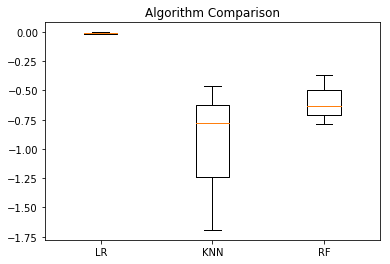

In [10]:
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=3)

    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [16]:
from sklearn.metrics import make_scorer
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score
rmse_score = make_scorer(rmse, greater_is_better = False)

In [ ]:
from sklearn.model_selection import GridSearchCV
# skip this cell, takes a very long time 
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,6)]}

tscv = TimeSeriesSplit(n_splits=3)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score, verbose=10)
print('done searching.Starting to train')
print('done training')
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [11]:
models[1]
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [12]:
best_model = models[1]


In [13]:
y_true = y_test.values
y_pred = knn.predict(X_test)
results = regression_results(y_true, y_pred)

explained_variance:  0.8339
r2:  0.8321
MAE:  4.7879
MSE:  78.182
RMSE:  8.8421


In [26]:
predicted_data = np.savetxt("predicted_data.csv", y_pred, delimiter=",")
true_data = np.savetxt("true_data.csv", y_true, delimiter=",")


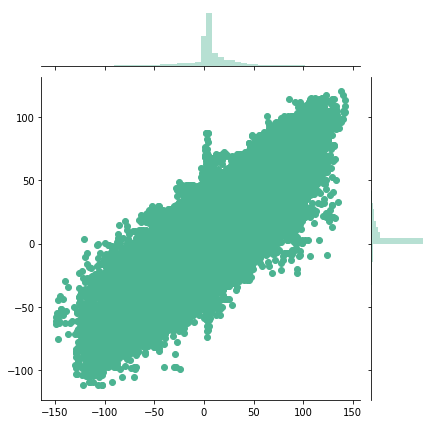

In [150]:
import seaborn as sns
#sns.set_theme()
sns.jointplot(x=y_true, y=y_pred, color="#4CB391")

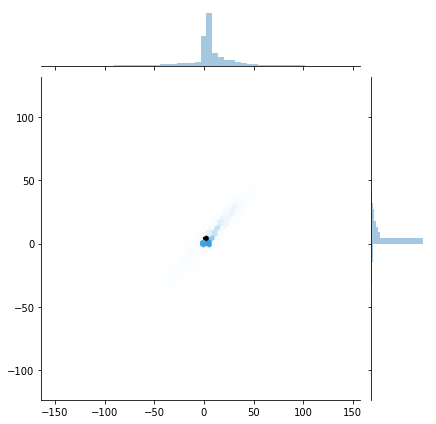

In [52]:
import seaborn as sns
#sns.set_theme(style="ticks")
sns.jointplot(data=penguins, x="bill_length_mm", y="bill_depth_mm")
sns.jointplot(x=y_true, y=y_pred, kind="hex")

In [14]:
# choose a pixel to plot the information from as a timeseries
no_duplicates_complete = no_duplicates_complete.reset_index()
no_duplicates_complete['time'] = pd.to_datetime(no_duplicates_complete['time'])
no_duplicates_complete = no_duplicates_complete.set_index('time')

In [15]:
no_duplicates_train = no_duplicates_complete[:'20170430']
no_duplicates_test = no_duplicates_complete['20170501':'20180501']

In [16]:
no_duplicates_test['new_pixel'] = no_duplicates_test['rows'].diff()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
no_duplicates_test.head()

,rows,cols,ground_motion,slope,curvature,aspect,datasource,distance_to_road,rain_intensity_mm_sec,new_pixel
time,,,,,,,,,,
2017-05-01,117,1792,49.49,0.065193,-0.001018,64.341156,0.0,2.386776e+09,4.605107e-06,NaN
2017-05-07,117,1792,48.80,0.065193,-0.001018,64.341156,0.0,2.386776e+09,1.059078e-04,0.0
2017-05-13,117,1792,46.31,0.065193,-0.001018,64.341156,0.0,2.386776e+09,3.144808e-07,0.0
2017-05-19,117,1792,35.88,0.065193,-0.001018,64.341156,0.0,2.386776e+09,6.743622e-07,0.0
2017-05-25,117,1792,30.59,0.065193,-0.001018,64.341156,0.0,2.386776e+09,2.740868e-06,0.0


In [18]:
# indicate where a new pixel appears on the dataframe
test_array_rows = no_duplicates_test['rows'].to_numpy()


In [24]:
test_array_rows_data = np.savetxt("test_array_rows_data.csv", test_array_rows, delimiter=",")

In [19]:
test_array_cols = no_duplicates_test['cols'].to_numpy()

In [25]:
test_array_cols_data = np.savetxt("test_array_cols_data.csv", test_array_cols, delimiter=",")

In [20]:
index_rows = np.where(test_array_rows[:-1] != test_array_rows[1:])[0]
index_cols = np.where(test_array_cols[:-1] != test_array_cols[1:])[0]

In [21]:
y_pred[:index_rows[0]]

array([35.126, 14.22 , 23.07 , 20.64 , 32.102, 23.854, 30.592, 33.254,
       14.674, 33.254, 33.254, 29.912, 21.664, 30.054, 21.666, 13.48 ,
       33.254, 18.648, 14.22 , 21.666, 30.592, 33.254, 26.994, 23.036,
       38.816, 14.22 , 21.666, 21.664, 33.254, 35.126, 30.592, 19.014,
       30.466, 35.126, 21.748, 30.582, 33.254, 14.674, 21.666, 14.22 ,
       30.054, 29.648, 21.664, 33.254, 38.816, 33.254, 30.466, 26.33 ,
       30.592, 25.926, 20.64 , 30.582, 30.054, 29.648, 17.182, 33.556])

Now we can plot the timeseries for some of the pixels individually.

In [22]:
start = index_rows[0]
end = index_rows[1]

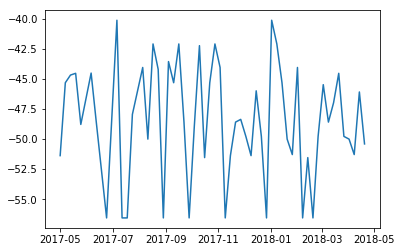

In [159]:
plt.plot(no_duplicates_test.index[start+1:end], y_pred[start+1:end])

In [ ]:
no_duplicates_test.index[start+1:end]

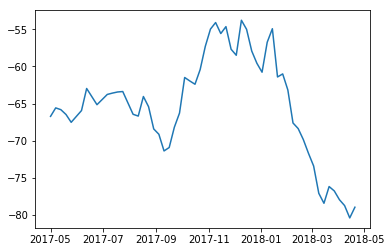

In [160]:
plt.plot(no_duplicates_test.index[start+1:end], y_true[start+1:end])

Convert pixel positions into map readable material so that we can have the DEM with the points as predicted by the model.
Follow the same strategy as for the maps plotted with the Visualisation scripts. 

In [3]:
# figure to plot the maps to visualise the pixels
# Load rasters into arrays for DEM.
from osgeo import gdal, ogr, osr
from osgeo.gdalnumeric import *
from osgeo.gdalconst import *
demarr, pixelWidth, (geotransform, inDs) = ENVI_raster_binary_to_2d_array(demfile)

# Read the road file
road = shapefile.Reader(roadfile)
roadline = np.array(road.shapes()[0].points)

# now convert it to pixel coordinates
roadline[:,0] = (roadline[:,0] - geotransform[0]) / geotransform[1] # X_coord
roadline[:,1] = (roadline[:,1] - geotransform[3]) / geotransform[5] # Y_coord
roadline = roadline.astype('int')
line = mlines.Line2D(roadline[:,0], roadline[:,1], linewidth = 1., color='black')


def map_predicted (demarr, predicted, road, fig_height, fig_width, fig_name):

    fig=plt.figure(1, facecolor='White',figsize=[fig_width, fig_height])
    ax1 =  plt.subplot2grid((1,1),(0,0),colspan=1, rowspan=1)


    dem_mask = np.ma.masked_where(demarr <= -10, demarr)
    Map1 = ax1.imshow(dem_mask, interpolation='None', cmap=plt.cm.Greys_r, vmin = np.amin(dem_mask), vmax = np.amax(dem_mask), alpha = 1.)

    ax1.add_line(road)

    predicted_arr = 0* demarr
    for i in range(len(predicted)):
        x = predicted['col'].iloc[i]
        y = predicted['row'].iloc[i]
        predicted_arr[y-2:y+2,x-2:x+2] = 1

    predicted_mask = np.ma.masked_where(predicted_arr == 0., predicted_arr)
    Map1 = ax1.imshow(predicted_mask, interpolation='None', cmap=plt.cm.autumn,
        vmin = 0, vmax = 1, alpha = 1.)
    plt.title("Predicted Ground Motion", fontsize = 26, pad = 10.)
    plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,
    left=False,        # ticks along the top edge are off
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off
    plt.tight_layout()
    plt.savefig(fig_name)

NameError: name 'ENVI_raster_binary_to_2d_array' is not defined

In [ ]:
map_calibrated(demarr, predicted, road, fig_height, fig_width, fig_name)

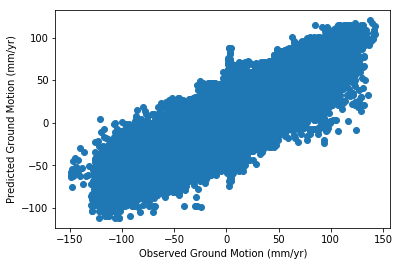

In [49]:
plt.scatter(y_true, y_pred)
plt.xlabel("Observed Ground Motion (mm/yr)")
plt.ylabel("Predicted Ground Motion (mm/yr)")
plt.savefig("10mDEM_predicted_obs_ground_motion_ml_no_duplicates_all_variables.png")

In [14]:
dates = result_with_rain.index

(array([4.37000e+02, 3.45500e+03, 1.94330e+04, 5.58280e+04, 5.42252e+05,
        2.38980e+05, 6.33740e+04, 1.45200e+04, 3.40400e+03, 3.50000e+02]),
 array([-113.126 ,  -89.3326,  -65.5392,  -41.7458,  -17.9524,    5.841 ,
          29.6344,   53.4278,   77.2212,  101.0146,  124.808 ]),
 <a list of 10 Patch objects>)

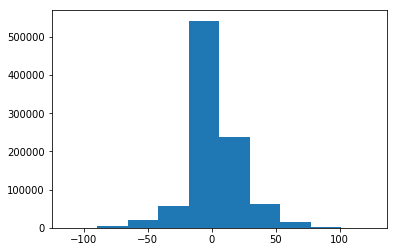

In [15]:
plt.hist(y_pred)

In [16]:
# get an array with all the predicted y values
# create a dataset where it should show dt instead of t
date_train = result_with_rain.index

In [17]:
dates_train = result_with_rain.index.values[:len(y_train)]
dates_test = result_with_rain.index.values[len(y_train):]

In [18]:
# index is reset to numerical instead of the time
result_with_rain_new = result_with_rain.reset_index()

In [19]:
result_with_rain_new.head()

,time,ground_motion,slope,curvature,aspect,distance_to_road,rain_intensity_mm_sec
0,2014-12-31,27.21,0.210794,-4.46151e-06,169.203,2.42918e+09,0.000024
1,2014-12-31,3.41,0.0280107,2.14703e-05,248.31,2.34173e+09,0.000024
2,2014-12-31,6.16,0.315373,-0.00186646,156.738,2.2327e+09,0.000024
3,2014-12-31,17.29,0.165681,4.60265e-07,194.658,2.25544e+09,0.000024
4,2014-12-31,13.92,0.164436,0.0253468,161.393,2.39873e+09,0.000024


In [21]:
# add the columns and rows corresponding to the pixels - the dataframe is in the same order so entries correspond
# also add the datasource
pred_result_with_rain_px_source = result_with_rain_complete
pred_result_with_rain_px_source = pred_result_with_rain_px_source['2018':]
pred_result_with_rain_px_source['pred_ground_motion'] = y_pred



/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [22]:
pred_result_with_rain_px_source.head()

,ground_motion,slope,curvature,aspect,rows,cols,datasource,distance_to_road,rain_intensity_mm_sec,pred_ground_motion
time,,,,,,,,,,
2018-01-02,-92.65,0.200227,0.00101186,206.844,357,2971,0,2.50042e+09,5.243585e-07,-62.680
2018-01-02,19.02,0.373238,-0.00314,321.926,626,653,0,2.27253e+09,5.243585e-07,2.934
2018-01-02,5.01,0.116304,-1.13085e-05,51.2097,2197,1349,0,2.32744e+09,5.243585e-07,18.074
2018-01-02,20.63,0.115839,-0.000154432,173.87,1269,2798,0,2.47537e+09,5.243585e-07,19.192
2018-01-02,10.91,0.0101393,-3.4791e-06,317.856,1614,1382,0,2.33436e+09,5.243585e-07,7.938


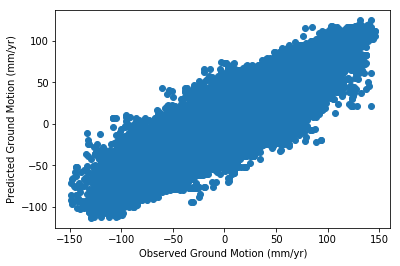

In [24]:
plt.scatter(pred_result_with_rain_px_source['ground_motion'], pred_result_with_rain_px_source['pred_ground_motion'])
plt.xlabel("Observed Ground Motion (mm/yr)")
plt.ylabel("Predicted Ground Motion (mm/yr)")
plt.savefig("10mDEM_predicted_obs_ground_motion_ml.png")

In [59]:
int(pred_result_with_rain_px_source.min(axis=0)['rows'])

4

In [61]:
pred_ground_motion_arr = np.zeros((pred_result_with_rain_px_source.shape[0], pred_result_with_rain_px_source.shape[1]))
for i in range(int(pred_result_with_rain_px_source.min(axis=0)['rows']), int(pred_result_with_rain_px_source.max(axis=0)['rows']),1):
    for j in range(int(pred_result_with_rain_px_source.min(axis=0)['cols']), int(pred_result_with_rain_px_source.max(axis=0)['cols']),1):
        row_value = pred_result_with_rain_px_source.loc[pred_result_with_rain_px_source['rows'] == i]
        print(row_value)
        col_value = pred_result_with_rain_px_source.loc[pred_result_with_rain_px_source['cols'] == j]
        print(col_value)
        pred_gm_value = pred_result_with_rain_px_source.loc[(pred_result_with_rain_px_source['cols'] == j) & (pred_result_with_rain_px_source['rows'] == i)]
        print(pred_gm_value)
        pred_ground_motion_arr[i,j] = pred_gm_value


            ground_motion      slope rows cols datasource distance_to_road  \
time                                                                         
2018-01-02          17.04  0.0505374    4  690          0           164089   
2018-01-08          14.89  0.0505374    4  690          0           164089   
2018-01-14          16.44  0.0505374    4  690          0           164089   
2018-01-20          18.65  0.0505374    4  690          0           164089   
2018-01-26          19.33  0.0505374    4  690          0           164089   
2018-02-01          20.45  0.0505374    4  690          0           164089   
2018-02-07          23.79  0.0505374    4  690          0           164089   
2018-02-13          24.55  0.0505374    4  690          0           164089   
2018-02-19          25.82  0.0505374    4  690          0           164089   
2018-02-25          26.26  0.0505374    4  690          0           164089   
2018-03-03          26.28  0.0505374    4  690          0       

Empty DataFrame
Columns: [ground_motion, slope, rows, cols, datasource, distance_to_road, rain_intensity_mm_sec, pred_ground_motion]
Index: []


ValueError: setting an array element with a sequence.

In [64]:
# Group data first by year, then by month
g = pred_result_with_rain_px_source.groupby(["time"])

# For each group, calculate the average of only the snow_depth column
monthly_averages = g.aggregate({"pred_ground_motion":np.mean})

In [ ]:
monthly_averages

In [ ]:
plt.imshow(pred_result_with_rain_px_source['pred_ground_motion'])

In [ ]:
# get time passed dataframe
df = pd.DataFrame(index=result_with_rain.index.values, columns=['time since'])

basedate = pd.Timestamp('2014-12-31')
df['time since'] = df.apply(lambda x: (x.name.to_pydatetime() - basedate).days, axis=1)
result_with_rain['time_since'] = df['time since']

In [ ]:
plt.scatter(df['time since'], result_with_rain['ground_motion'])

In [28]:
df_threshold = result_with_rain[result_with_rain['ground_motion'] >= 80]


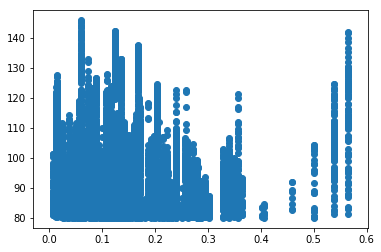

In [29]:
plt.scatter(df_threshold['slope'], df_threshold['ground_motion'])

In [ ]:
plt.hist(df_threshold['slope'])

In [91]:
df_threshold.head()

,ground_motion,slope,distance_to_road,rain_intensity_mm_sec,time_since
time,,,,,
2015-03-25,82.24,0.124795,54965,1.413031e-04,84
2015-04-06,86.17,0.076304,38530,1.639528e-06,96
2015-04-06,91.49,0.124795,54965,1.639528e-06,96
2015-04-30,87.91,0.0600391,86193,9.664785e-08,120
2015-04-30,82.12,0.127192,135865,9.664785e-08,120
